In [1]:
import os 
import numpy as np
import pandas as pd 
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
from statsmodels.formula.api import ols
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from patsy import dmatrices
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

In [2]:
os.getcwd()

'C:\\Users\\rhian\\Downloads\\Capstone\\drugs\\Analysis\\Modeling'

In [3]:
def compute_rmse(predictions, yvalues): 
    rmse = np.sqrt(np.sum(np.subtract(yvalues, predictions)**2)/len(yvalues))
    return rmse 

In [4]:
# Navigating to csv file
os.chdir('C:\\Users\\rhian\\Downloads\\Capstone\\drugs\\Data')
od = pd.read_csv('od_nonull.csv')
od.head()

,Year,FIPS,County,State,Region,Division,Overdose_Deaths,Overdose_Pop,Overdose_Rate_per_100k,Population,...,Pct_Unemployed,Pct_Poverty,Median_HHI,Jail_Pop,Urbanicity,Spatial_Max,Spatial_Mean,Prev_Spatial_Max,Prev_Spatial_Mean,Geometry
0,2011,1003,"Baldwin County, AL",Alabama,South,East South Central,24.0,186717.0,12.853677,179878.0,...,9.0,13.4,50144.0,743.36,2.0,42.000263,21.667119,26.096714,16.138937,"POLYGON ((-87.598927 30.997454, -87.594111 30...."
1,2011,1015,"Calhoun County, AL",Alabama,South,East South Central,14.0,117797.0,11.884853,114081.0,...,10.3,20.9,39060.0,504.25,2.0,21.327520,17.854349,17.944086,14.717519,"POLYGON ((-86.145562 33.679098, -86.043993 33...."
2,2011,1043,"Cullman County, AL",Alabama,South,East South Central,10.0,80536.0,12.416807,81778.0,...,9.5,18.2,39395.0,312.43,1.0,55.504718,34.421638,50.728854,27.746062,"POLYGON ((-87.109911 34.299299, -87.110111 34...."
3,2011,1049,"De Kalb County, AL",Alabama,South,East South Central,11.0,71375.0,15.411559,69380.0,...,11.7,20.3,35487.0,204.54,1.0,17.429700,15.905439,14.544185,13.017568,"POLYGON ((-85.513709 34.52417, -85.513699 34.5..."
4,2011,1053,"Escambia County, AL",Alabama,South,East South Central,16.0,38095.0,42.000263,37434.0,...,10.7,25.5,32838.0,192.75,1.0,16.222811,13.108417,15.194356,12.847718,"POLYGON ((-87.163084 30.999051, -87.25498 30.9..."


# Create the previous years od rate 

In [5]:
os.chdir('C:\\Users\\rhian\\Downloads\\Capstone\\drugs\\Data\\Geographical_Data')
od10 = pd.read_csv('od_counties_full_w2010.csv')
od10['Year'] = od10['Year'] + 1
od10 = od10[['Year', 'FIPS', 'Overdose_Rate_per_100k']]
od10

,Year,FIPS,Overdose_Rate_per_100k
0,2011,1001,NaN
1,2011,1003,14.264944
2,2011,1005,NaN
3,2011,1007,NaN
4,2011,1009,17.445309
...,...,...,...
34557,2021,56037,35.151032
34558,2021,56039,NaN
34559,2021,56041,NaN
34560,2021,56043,NaN


In [6]:
od = od.merge(od10, on = ['Year', 'FIPS'], how = 'left') 
od.rename(columns={'Overdose_Rate_per_100k_x':'Overdose_Rate_per_100k', 'Overdose_Rate_per_100k_y':'Prev_Overdose_Rate'}, inplace=True)
od

,Year,FIPS,County,State,Region,Division,Overdose_Deaths,Overdose_Pop,Overdose_Rate_per_100k,Population,...,Pct_Poverty,Median_HHI,Jail_Pop,Urbanicity,Spatial_Max,Spatial_Mean,Prev_Spatial_Max,Prev_Spatial_Mean,Geometry,Prev_Overdose_Rate
0,2011,1003,"Baldwin County, AL",Alabama,South,East South Central,24.0,186717.0,12.853677,179878.0,...,13.4,50144.0,743.36,2.0,42.000263,21.667119,26.096714,16.138937,"POLYGON ((-87.598927 30.997454, -87.594111 30....",14.264944
1,2011,1015,"Calhoun County, AL",Alabama,South,East South Central,14.0,117797.0,11.884853,114081.0,...,20.9,39060.0,504.25,2.0,21.327520,17.854349,17.944086,14.717519,"POLYGON ((-86.145562 33.679098, -86.043993 33....",17.710758
2,2011,1043,"Cullman County, AL",Alabama,South,East South Central,10.0,80536.0,12.416807,81778.0,...,18.2,39395.0,312.43,1.0,55.504718,34.421638,50.728854,27.746062,"POLYGON ((-87.109911 34.299299, -87.110111 34....",NaN
3,2011,1049,"De Kalb County, AL",Alabama,South,East South Central,11.0,71375.0,15.411559,69380.0,...,20.3,35487.0,204.54,1.0,17.429700,15.905439,14.544185,13.017568,"POLYGON ((-85.513709 34.52417, -85.513699 34.5...",NaN
4,2011,1053,"Escambia County, AL",Alabama,South,East South Central,16.0,38095.0,42.000263,37434.0,...,25.5,32838.0,192.75,1.0,16.222811,13.108417,15.194356,12.847718,"POLYGON ((-87.163084 30.999051, -87.25498 30.9...",26.096714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7492,2020,55131,"Washington County, WI",Wisconsin,Midwest,East North Central,31.0,136445.0,22.719777,135693.0,...,5.1,81659.0,229.00,3.0,53.649885,29.180797,42.401287,20.457328,"POLYGON ((-88.040528 43.542361, -88.063353 43....",16.172427
7493,2020,55133,"Waukesha County, WI",Wisconsin,Midwest,East North Central,97.0,406172.0,23.881508,403072.0,...,4.2,92359.0,350.00,3.0,53.649885,28.667630,42.401287,22.396738,"POLYGON ((-88.542026 42.93094, -88.539619 43.1...",15.586421
7494,2020,55139,"Winnebago County, WI",Wisconsin,Midwest,East North Central,38.0,171631.0,22.140522,171020.0,...,8.7,64653.0,310.00,2.0,26.238557,20.006112,12.572169,11.874609,"POLYGON ((-88.404043 44.226903, -88.404425 44....",11.634198
7495,2020,55141,"Wood County, WI",Wisconsin,Midwest,East North Central,18.0,72560.0,24.807056,73055.0,...,9.4,54154.0,94.00,1.0,10.325017,10.325017,11.791410,11.791410,"POLYGON ((-89.902565 44.24947, -90.312035 44.2...",16.438581


# Modeling prev overdose rate 

In [37]:
y, X = dmatrices("Overdose_Rate_per_100k ~ Prev_Overdose_Rate", 
                 data=od, return_type='dataframe')
y = np.log(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=30)

In [40]:
mod = sm.OLS(y_train, x_train)
res = mod.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     Overdose_Rate_per_100k   R-squared:                       0.618
Model:                                OLS   Adj. R-squared:                  0.618
Method:                     Least Squares   F-statistic:                     7929.
Date:                    Thu, 28 Apr 2022   Prob (F-statistic):               0.00
Time:                            15:23:57   Log-Likelihood:                -1741.2
No. Observations:                    4895   AIC:                             3486.
Df Residuals:                        4893   BIC:                             3499.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [50]:
y_test_pred = res.predict(x_test)
print('test R2:', r2_score(y_test, y_test_pred))
print('test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred)))

test R2: 0.6227804831731547
test RMSE: 0.346174476723471


# Modeling spatmean

In [55]:
y, X = dmatrices("Overdose_Rate_per_100k ~ Spatial_Mean", 
                 data=od, return_type='dataframe')
y = np.log(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=30)

In [56]:
mod = sm.OLS(y_train, x_train)
res = mod.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     Overdose_Rate_per_100k   R-squared:                       0.454
Model:                                OLS   Adj. R-squared:                  0.454
Method:                     Least Squares   F-statistic:                     4680.
Date:                    Thu, 28 Apr 2022   Prob (F-statistic):               0.00
Time:                            15:35:34   Log-Likelihood:                -2967.3
No. Observations:                    5622   AIC:                             5939.
Df Residuals:                        5620   BIC:                             5952.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercep

In [57]:
y_test_pred = res.predict(x_test)
print('test R2:', r2_score(y_test, y_test_pred))
print('test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred)))

test R2: 0.47334403350054155
test RMSE: 0.4158020000342389


#### prev year's time component > current year's geographical component 

# Modeling prev overdose rate & spatmean 

In [52]:
y, X = dmatrices("Overdose_Rate_per_100k ~ Prev_Overdose_Rate + Spatial_Mean", 
                 data=od, return_type='dataframe')
y = np.log(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=30)

In [53]:
mod = sm.OLS(y_train, x_train)
res = mod.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     Overdose_Rate_per_100k   R-squared:                       0.665
Model:                                OLS   Adj. R-squared:                  0.665
Method:                     Least Squares   F-statistic:                     4856.
Date:                    Thu, 28 Apr 2022   Prob (F-statistic):               0.00
Time:                            15:34:29   Log-Likelihood:                -1422.1
No. Observations:                    4895   AIC:                             2850.
Df Residuals:                        4892   BIC:                             2870.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [54]:
y_test_pred = res.predict(x_test)
print('test R2:', r2_score(y_test, y_test_pred))
print('test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred)))

test R2: 0.6746030899919294
test RMSE: 0.3215175467511693


# Naive Backward Selection 
### (see if it chooses prev_od_rate & spat_mean) 

In [10]:
od_model = od.drop(['FIPS', 'County', 'State', 'Region', 'Division', 'Overdose_Deaths', 'Overdose_Pop', 'Geometry'], axis=1)
od_model.rename(columns={'Pct_Age<18':'Pct_Age_lt_18', 'Pct_Age>=65':'Pct_Age_gte_65'}, inplace=True)
od_model = od_model.dropna()
od_model = od_model.reset_index(drop=True)
od_model 

,Year,Overdose_Rate_per_100k,Population,Pct_Age_lt_18,Pct_Age_gte_65,Pct_Black,Pct_Native,Pct_Asian,Pct_Pacific_Islander,Pct_Hispanic,...,Pct_Unemployed,Pct_Poverty,Median_HHI,Jail_Pop,Urbanicity,Spatial_Max,Spatial_Mean,Prev_Spatial_Max,Prev_Spatial_Mean,Prev_Overdose_Rate
0,2011,12.853677,179878.0,23.100000,17.000000,10.000000,0.500000,0.600000,0.000000,3.300000,...,9.0,13.4,50144.0,743.36,2.0,42.000263,21.667119,26.096714,16.138937,14.264944
1,2011,11.884853,114081.0,23.400000,15.000000,20.000000,0.400000,0.800000,0.100000,2.600000,...,10.3,20.9,39060.0,504.25,2.0,21.327520,17.854349,17.944086,14.717519,17.710758
2,2011,42.000263,37434.0,23.000000,15.200000,32.100000,3.100000,0.300000,0.000000,1.500000,...,10.7,25.5,32838.0,192.75,1.0,16.222811,13.108417,15.194356,12.847718,26.096714
3,2011,14.381178,103645.0,23.300000,16.200000,14.800000,0.400000,0.500000,0.000000,3.300000,...,10.0,21.0,34927.0,768.57,2.0,21.327520,16.207977,17.944086,17.700051,11.490951
4,2011,12.899681,665027.0,23.800000,13.600000,40.900000,0.400000,1.400000,0.100000,3.600000,...,9.2,18.7,42053.0,1532.75,4.0,55.504718,25.407144,50.728854,22.663279,9.112088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6522,2020,22.719777,135693.0,21.903856,17.985452,1.243985,0.392798,1.459176,0.042744,3.220505,...,5.6,5.1,81659.0,229.00,3.0,53.649885,29.180797,42.401287,20.457328,16.172427
6523,2020,23.881508,403072.0,21.508564,18.654235,1.590287,0.324012,3.886651,0.054581,4.786986,...,5.6,4.2,92359.0,350.00,3.0,53.649885,28.667630,42.401287,22.396738,15.586421
6524,2020,22.140522,171020.0,20.515144,16.385218,2.170506,0.746112,3.045843,0.053210,4.200094,...,5.4,8.7,64653.0,310.00,2.0,26.238557,20.006112,12.572169,11.874609,11.634198
6525,2020,24.807056,73055.0,21.556362,20.562590,0.880159,0.932174,2.003970,0.031483,3.092191,...,6.7,9.4,54154.0,94.00,1.0,10.325017,10.325017,11.791410,11.791410,16.438581


In [20]:
train_rmse_list = []
test_rmse_list = []
best_features = []
n_features_list  = []
cv_round_list = []
lr = LinearRegression()

y = od_model[['Overdose_Rate_per_100k']]
X_int = od_model.drop('Overdose_Rate_per_100k', axis=1)
X_int.insert(0, 'Intercept', 1)

X = np.array(X_int)
y = np.array(np.log(y))
X_columns = X_int.columns

cv_round = 0


kf = KFold(n_splits=5, random_state=0, shuffle=True)
for train_index, test_index in kf.split(od_model):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    cv_round = cv_round + 1 
    
    for i in range(1, 38):
        
        sfs = SequentialFeatureSelector(lr, n_features_to_select=i, 
                                        direction='backward', scoring='neg_mean_squared_error', 
                                        cv = 5)
        sfs.fit(X_train, y_train)

        best_cols = sfs.get_support()
        best_cols = [i for i, x in enumerate(best_cols) if x]
        best_cols = X_columns[best_cols].tolist()
        best_features.append(best_cols)

        X_subset = np.array(X_int[best_cols]).reshape(od_model.shape[0], len(best_cols))
        X_subtrain = X_subset[train_index]
        X_subtest = X_subset[test_index]

        lr.fit(X_subtrain, y_train)
        yhat_train = lr.predict(X_subtrain)
        train_rmse = np.sqrt(mean_squared_error(y_train, yhat_train))
        train_rmse_list.append(train_rmse)

        yhat_test = lr.predict(X_subtest)
        test_rmse = np.sqrt(mean_squared_error(y_test, yhat_test))
        test_rmse_list.append(test_rmse)
        
        n_features_list.append(i)
        cv_round_list.append(cv_round)

best_features_naive = best_features.copy() 
score_board = pd.DataFrame(train_rmse_list, columns=['train_rmse'])
score_board['test_rmse'] = test_rmse_list
score_board.insert(0, 'n_features', n_features_list)
score_board.insert(1, 'best_features', best_features)
score_board.insert(0, 'cv_round', cv_round_list)
score_board_naive = score_board.copy()
score_board_naive

,cv_round,n_features,best_features,train_rmse,test_rmse
0,1,1,[Prev_Overdose_Rate],0.346846,0.340367
1,1,2,"[Spatial_Mean, Prev_Overdose_Rate]",0.323342,0.322285
2,1,3,"[Pct_Child_in_1ParentHH, Spatial_Mean, Prev_Ov...",0.317135,0.316861
3,1,4,"[Year, Pct_Child_in_1ParentHH, Spatial_Mean, P...",0.313448,0.311625
4,1,5,"[Year, Pct_Hispanic, Pct_Child_in_1ParentHH, S...",0.308149,0.307198
...,...,...,...,...,...
180,5,33,"[Intercept, Year, Pct_Age_lt_18, Pct_Black, Pc...",0.290967,0.286318
181,5,34,"[Intercept, Year, Pct_Age_lt_18, Pct_Black, Pc...",0.290955,0.286436
182,5,35,"[Intercept, Year, Population, Pct_Age_lt_18, P...",0.290950,0.286433
183,5,36,"[Intercept, Year, Population, Pct_Age_lt_18, P...",0.290918,0.286287


In [25]:
for i in score_board_naive[score_board_naive['n_features'] == 6]['best_features']:
    print(i)

['Year', 'Pct_Black', 'Pct_Hispanic', 'Pct_Child_in_1ParentHH', 'Spatial_Mean', 'Prev_Overdose_Rate']
['Year', 'Pct_Black', 'Pct_Hispanic', 'Pct_Child_in_1ParentHH', 'Spatial_Mean', 'Prev_Overdose_Rate']
['Year', 'Pct_Black', 'Pct_Hispanic', 'Pct_Child_in_1ParentHH', 'Spatial_Mean', 'Prev_Overdose_Rate']
['Year', 'Pct_Black', 'Pct_Hispanic', 'Pct_Child_in_1ParentHH', 'Spatial_Mean', 'Prev_Overdose_Rate']
['Year', 'Pct_Black', 'Pct_Hispanic', 'Pct_Child_in_1ParentHH', 'Spatial_Mean', 'Prev_Overdose_Rate']


In [21]:
score_naive_means = score_board_naive.groupby('n_features').mean().reset_index()
score_naive_means

,n_features,cv_round,train_rmse,test_rmse
0,1,3.0,0.345474,0.345731
1,2,3.0,0.322960,0.323416
2,3,3.0,0.317070,0.318079
3,4,3.0,0.312964,0.313381
4,5,3.0,0.307842,0.308326
5,6,3.0,0.302866,0.303363
6,7,3.0,0.301011,0.302339
7,8,3.0,0.299449,0.300575
8,9,3.0,0.297884,0.299366
9,10,3.0,0.296783,0.297719


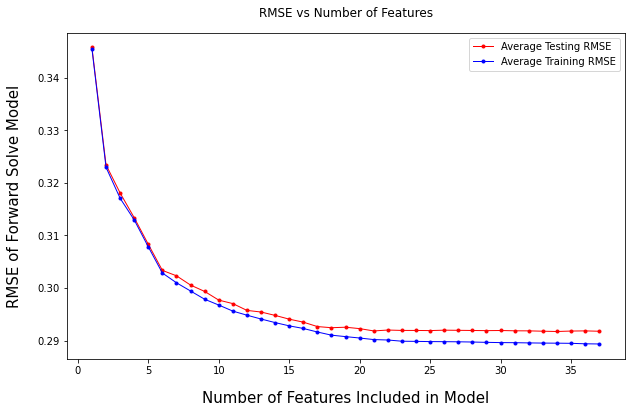

In [22]:
plt.figure(figsize=(10,6))
plt.plot(score_naive_means['n_features'], score_naive_means['test_rmse'], color="red", label="Average Testing RMSE", linewidth=1, marker='.')
plt.plot(score_naive_means['n_features'], score_naive_means['train_rmse'], color="blue", label="Average Training RMSE", linewidth=1, marker='.')
# plt.plot(optim_Lambda, best_test_rmse, marker='o', color='goldenrod', alpha=0.4, markersize = 15)
# plt.text(optim_Lambda, best_test_rmse-.04, 'Optimal Lambda: {:.4f}'.format(Lambda[14]), 
#          color='goldenrod')
plt.title("RMSE vs Number of Features", y=1.03)
plt.xlabel("Number of Features Included in Model", fontsize=15, labelpad=15)
plt.ylabel("RMSE of Forward Solve Model", fontsize=15, labelpad=15)
plt.legend()
plt.show()  

In [27]:
y, X = dmatrices("Overdose_Rate_per_100k ~ Year + Pct_Black + Pct_Hispanic + \
                 Pct_Child_in_1ParentHH + Spatial_Mean ", 
                 data=od_model, return_type='dataframe')
y = np.log(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=30)

mod = sm.OLS(y_train, x_train)
res = mod.fit()
print(res.summary())


                              OLS Regression Results                              
Dep. Variable:     Overdose_Rate_per_100k   R-squared:                       0.576
Model:                                OLS   Adj. R-squared:                  0.576
Method:                     Least Squares   F-statistic:                     1330.
Date:                    Fri, 29 Apr 2022   Prob (F-statistic):               0.00
Time:                            13:27:31   Log-Likelihood:                -1996.6
No. Observations:                    4895   AIC:                             4005.
Df Residuals:                        4889   BIC:                             4044.
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [30]:

y_test_pred = res.predict(x_test)
print('test R2:', r2_score(y_test, y_test_pred))
print('test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred)))

test R2: 0.5892407237305519
test RMSE: 0.36123652611217366


In [31]:
odm18 = od_model[od_model['Year'] == 2018]
y, X = dmatrices("Overdose_Rate_per_100k ~ Year + Pct_Black + Pct_Hispanic + \
                 Pct_Child_in_1ParentHH + Spatial_Mean + Prev_Overdose_Rate", 
                 data=odm18, return_type='dataframe')
y = np.log(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=30)

mod = sm.OLS(y_train, x_train)
res = mod.fit()
print(res.summary())


                              OLS Regression Results                              
Dep. Variable:     Overdose_Rate_per_100k   R-squared:                       0.666
Model:                                OLS   Adj. R-squared:                  0.663
Method:                     Least Squares   F-statistic:                     216.8
Date:                    Fri, 29 Apr 2022   Prob (F-statistic):          7.52e-127
Time:                            13:36:37   Log-Likelihood:                -137.53
No. Observations:                     549   AIC:                             287.1
Df Residuals:                         543   BIC:                             312.9
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

# 